# Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.set_default_tensor_type('torch.DoubleTensor')

# NN Model

In [2]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(12, 25)
        self.fc2 = nn.Linear(25, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [3]:
def read_weight(filename):
    model_weight = torch.load(filename)
    model = Network()
    model.load_state_dict(model_weight)
    return model

# Drone

**Dynamics**
$$m\ddot{z} = -mg + u + f_a(z,\dot{z}),\quad 0 \leq u \leq 1.7mg$$

In [10]:
class Drone:

    def __init__(self, init_z=1.5, init_v=0, C=1.0, h_d=0.0, delay=0.2, oracle=False):
        # Drone parameters
        self.mass = 1.47                  # mass
        self.g = 9.81                     # gravity
        self.drone_height = 0.09          # drone's self-height
        self.delay = delay                # control delay, 0 if there is no delay
        self.thrust_max = 1.7             # control constrain, 0 <= u <= 1.7mg
        
        # NN model for unknown dynamics
        self.Fa_model = read_weight('Fa_net_12_3_full_Lip16.pth')

        # Control parameters
        self.gain = 1.0
        self.oracle = oracle

        # Desired trajectory parameters
        self.C = C                        # how fast to land
        self.h_d = h_d                    # desired landing height 
        
        # Real states
        self.init_z = init_z
        self.z = init_z                   # height
        self.v = init_v                   # velocity
        self.a = 0                        # acceleration
        self.u_d = 0                      # desired control signal
        self.u = 0                        # control signal              
        self.prev_u = 6508                # previous control signal
        self.Fa = 0                       # observed Fa
        self.Fa_nn = 0                    # Fa directly from the NN model

        # Noise
        self.a_noise_sigma = 0.1
        self.u_noise_sigma = 0
        self.a_noise = 0
        self.u_noise = 0

        # Step
        self.step_size = 1e-2
        self.total_step = 0 
        self.sim_duration = 10
        
    def noise(self):
        # Noise freq is 10
        if not self.total_step % int(1 / self.step_size * 0.1): 
            self.a_noise = np.random.normal(0, self.a_noise_sigma)
            if self.a_noise > 3 * self.a_noise_sigma:
                self.a_noise = 3 * self.a_noise_sigma
            if self.a_noise < -3 * self.a_noise_sigma:
                self.a_noise = -3 * self.a_noise_sigma

            self.u_noise = np.random.normal(0, self.u_noise_sigma)
            if self.u_noise > 3 * self.u_noise_sigma:
                self.u_noise = 3 * self.u_noise_sigma
            if self.u_noise < -3 * self.u_noise_sigma:
                self.u_noise = -3 * self.u_noise_sigma
                
    def baseline_controller(self):
        t = self.step_size * self.total_step
        z_d = np.exp(-self.C*t) * (1+self.C*t) * (self.init_z-self.h_d) + self.h_d
        z_dot_d = np.exp(-self.C*t) * (-self.C**2*t) * (self.init_z-self.h_d)
        z_ddot_d = np.exp(-self.C*t) * (self.C**3*t-self.C**2)

        # Here mean is the mean of Fa_hat
        mean = 0
        if self.oracle:
            mean = self.Fa_nn

        self.u_d = self.mass * (self.g + z_ddot_d - 2*self.gain*(self.v-z_dot_d) - self.gain**2*(self.z-z_d)) - mean
        
        # Consider control delay
        u = (1-self.delay) * self.prev_u + self.delay * self.u_d 
        
        # Control constrain
        if u > self.thrust_max*self.mass*self.g:
            u = self.thrust_max*self.mass*self.g
        if u < 0:
            u = 0

        # Control noise
        u = u + self.u_noise

        self.u = u
        self.prev_u = u
        
    def dynamics(self):
        # use prediction from NN as ground truth
        state = np.zeros([1,12])
        state[0,0] = self.z + self.drone_height
        state[0,3] = self.v
        state[0,7] = 1.0
        state[0,8:12] = 6508.0/8000
        state_torch = torch.from_numpy(state)
        Fa = self.Fa_model(state_torch)[0, 2].item()
        self.a = self.u/self.mass - self.g + self.a_noise + Fa/self.mass
        self.Fa_nn = Fa

    # ODE solver: Euler
    def process(self):
        self.noise()
        self.baseline_controller()
        self.dynamics()
        
        self.z = self.z + self.step_size * self.v
        self.v = self.v + self.step_size * self.a
                
        self.Fa = self.mass * (self.a + self.g) - self.u
        self.total_step += 1

    def simulate(self):
        Height = []
        Height = np.append(Height, self.z)
        Velocity = []
        Velocity = np.append(Velocity, self.v)
        Control = []
        Acceleration = []
        Fa = []
        Fa_nn = []

        while True:
            self.process()
            Height = np.append(Height, self.z)
            Velocity = np.append(Velocity, self.v)
            Control = np.append(Control, self.u)
            Acceleration = np.append(Acceleration, self.a)
            Fa = np.append(Fa, self.Fa)
            Fa_nn = np.append(Fa_nn, self.Fa_nn)

            if not self.total_step % int(1 / self.step_size):
                print('Simulation time: ' + str(self.total_step*self.step_size))

            if self.step_size*self.total_step >= self.sim_duration:
                break

        return Height[:-1], Velocity[:-1], Control, Acceleration, Fa, Fa_nn

# Simulation

In [17]:
def sim(drone):
    Height, Velocity, Control, Acceleration, Fa, Fa_nn = drone.simulate()
    time = np.linspace(drone.step_size, drone.sim_duration, len(Height))

    plt.figure(figsize=(12,7))
    plt.subplot(2, 3, 1)
    plt.plot(time[:], Height)
    plt.xlabel("time [s]")
    plt.ylabel("height [m]")
    plt.title("height")
    plt.hlines(y=0, xmin=drone.step_size, xmax=drone.sim_duration, color='r', linestyles='--')

    plt.subplot(2, 3, 2)
    plt.plot(time[:], Velocity)
    plt.xlabel("time [s]")
    plt.ylabel("velocity [m/s]")
    plt.title("velocity")
    plt.hlines(y=0, xmin=drone.step_size, xmax=drone.sim_duration, color='r', linestyles='--')

    plt.subplot(2, 3, 3)
    plt.plot(time[:], Control)
    plt.xlabel("time [s]")
    plt.ylabel("control [rps]")
    plt.title("control")

    plt.subplot(2, 3, 4)
    plt.plot(Velocity, Height)
    plt.xlabel("velocity [m/s]")
    plt.ylabel("height [m]")
    plt.title("velocity v.s. height")

    plt.subplot(2, 3, 5)
    plt.plot(time[:], Fa)
    plt.xlabel("time [s]")
    plt.ylabel("Fa [N]")
    plt.title("Fa")
    
    plt.subplot(2, 3, 6)
    plt.plot(time[:], Fa_nn)
    plt.xlabel("time [N]")
    plt.ylabel("Fa_nn [N]")
    plt.title("Fa_nn")
    
    plt.tight_layout()
    plt.show()

Simulation time: 1.0
Simulation time: 2.0
Simulation time: 3.0
Simulation time: 4.0
Simulation time: 5.0
Simulation time: 6.0
Simulation time: 7.0
Simulation time: 8.0
Simulation time: 9.0
Simulation time: 10.0


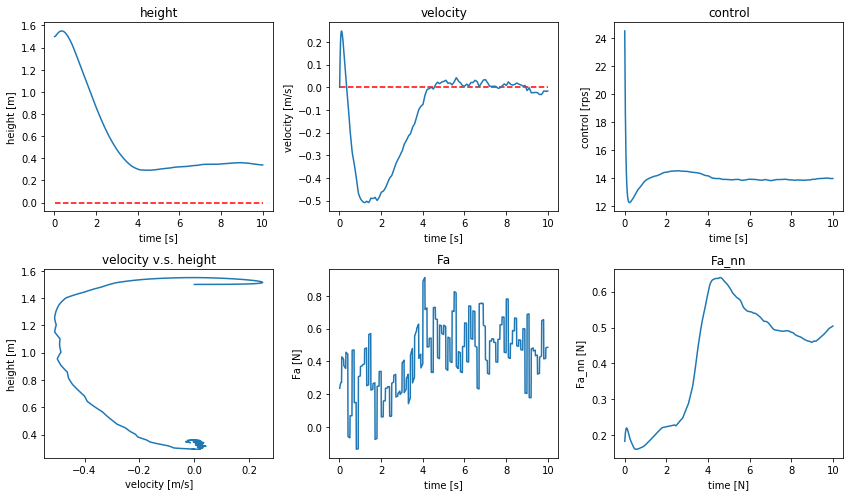

In [18]:
drone = Drone()
sim(drone)

Simulation time: 1.0
Simulation time: 2.0
Simulation time: 3.0
Simulation time: 4.0
Simulation time: 5.0
Simulation time: 6.0
Simulation time: 7.0
Simulation time: 8.0
Simulation time: 9.0
Simulation time: 10.0


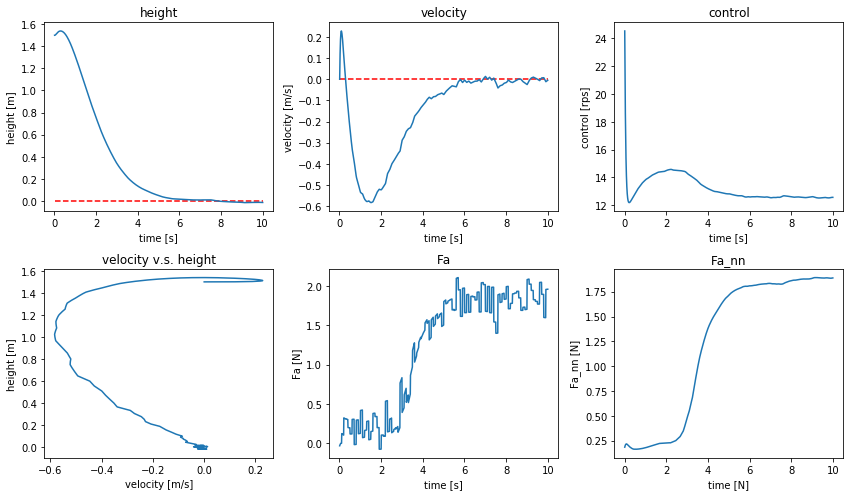

In [19]:
drone = Drone(oracle=True)
sim(drone)